In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Input Data Description
1. The origins of your data. Where did you get the data? How were the data collected from the original sources?  
2. The structure, granularity, scope, temporality and faithfulness (SGSTF) of your data. To discuss these attributes you should load the data into one or more data frames (so you'll start building code cells for the first time). At a minimum, use some basic methods (.head, .loc, and so on) to provide support for the descriptions you provide for SGSTF.

This dataset is from [nu3](https://www.nu3.de/blogs/nutrition/food-carbon-footprint-index-2018), a German online personal wellness and grocery store that performed some research to look at the CO2 emissions per person for 130 nations worldwide. Their study utilized 2018 data from the Food and Agriculture Organization of the United Nations (FAO) that described the amount of food supply for consumption by food item and nation. They also used the following assumptions as the estimated CO2 emissions per kilogram for each food type in 2018:

- Pork = 3.54 kg
- Poultry= 1.07 kg
- Beef = 30.86 kg
- Lamb & Goat = 35.02 kg
- Fish = 1.60 kg
- Eggs = 0.92 kg
- Milk – including cheese = 1.42 kg
- Wheat & Wheat Products = 0.19 kg
- Rice = 1.28 kg
- Soybeans = 0.45 kg
- Nuts – including Peanut Butter = 1.77 kg

### Data Acquisition and SGSTF

First, we grab the raw html from the website, and clean up the data to put it in a readable format.

In [61]:
# https://www.nu3.de/blogs/nutrition/food-carbon-footprint-index-2018
data = pd.read_html("https://www.nu3.de/blogs/nutrition/food-carbon-footprint-index-2018")[0]
data = data.droplevel([0,1], axis=1)
columns = ['#', 'Country', 'porksupply', 'porkco2', 'chickensupply', 'chickenco2', 'beefsupply', 'beefco2', 'lambsupply', 'lambco2', 
           'fishsupply', 'fishco2', 'eggsupply', 'eggco2', 'milkcheesesupply', 'milkcheeseco2', 'totalanimalco2', 
           'wheatprodsupply', 'wheatprodco2', 'ricesupply', 'riceco2', 'soybeansupply', 'soybeanco2', 
           'nutssupply', 'nutsco2', 'totalnonanimalco2', 'difftotalco2']

data.rename(columns=dict(zip(data.columns, columns)), inplace=True)
data.head()

,#,Country,porksupply,porkco2,chickensupply,chickenco2,beefsupply,beefco2,lambsupply,lambco2,...,wheatprodsupply,wheatprodco2,ricesupply,riceco2,soybeansupply,soybeanco2,nutssupply,nutsco2,totalnonanimalco2,difftotalco2
0,1,Argentina,10.51,37.20,38.66,41.53,55.48,1712.00,1.56,54.63,...,103.11,19.66,8.77,11.22,0.00,0.00,0.49,0.87,31.75,2108.90
1,2,Australia,24.14,85.44,46.12,49.54,33.86,1044.85,9.87,345.65,...,70.46,13.44,11.03,14.12,0.19,0.09,8.73,15.45,43.09,1852.46
2,3,Albania,10.88,38.51,13.23,14.21,22.50,694.30,15.32,536.50,...,138.64,26.44,7.78,9.96,0.00,0.00,4.36,7.72,44.11,1689.62
3,4,Iceland,21.69,76.77,26.87,28.86,13.36,412.26,21.12,739.62,...,72.92,13.91,3.89,4.98,0.11,0.05,3.88,6.87,25.80,1679.75
4,5,New Zealand,22.29,78.90,34.98,37.58,22.49,693.99,18.91,662.23,...,76.91,14.67,9.16,11.72,0.44,0.20,8.22,14.55,41.14,1668.67


In [62]:
data.columns

Index(['#', 'Country', 'porksupply', 'porkco2', 'chickensupply', 'chickenco2',
       'beefsupply', 'beefco2', 'lambsupply', 'lambco2', 'fishsupply',
       'fishco2', 'eggsupply', 'eggco2', 'milkcheesesupply', 'milkcheeseco2',
       'totalanimalco2', 'wheatprodsupply', 'wheatprodco2', 'ricesupply',
       'riceco2', 'soybeansupply', 'soybeanco2', 'nutssupply', 'nutsco2',
       'totalnonanimalco2', 'difftotalco2'],
      dtype='object')

In [63]:
# 130 different countries
data.shape

(130, 27)

**`Structure:`**  
The data came from html hosted on the `nu3` website, but was also held in a tabular format so it was easy to transfer it into a Jupyter notebook. 

**`Granularity:`**  
Each row in the raw dataset represents a country and its supply of each food in kilograms per person per year. Other information contained in each row include the conversion of that food supply into kilograms of carbon dioxide emissions per person per year. All rows are at the same granularity, but there are columns summarizing the carbon dioxide values of each record.

The spatial granularity is by country.  There are 130 countries included in total. The granularity in food groups is limited to common foods that people eat that are significant carbon dioxide emitters, such as meats, dairy, eggs, grains, soybeans, and nuts.

**`Scope:`**  
The data helps relate an average person's diet in a given country to their carbon footprint emissions. If we let each record represent a real life person with a particular diet, this can be useful data to help us understand how our own diet contributes to our carbon emissions. The scope is a good fit for the prediction problem.

**`Temporality:`**  
The data was collected in 2018, and used carbon emission estimates of each food by kilogram from 2017.

**`Faithfulness:`**  
The data originated from FAO, which is a reliable source. There are no missing values in this dataset, so cleaning will be fairly straightforward, and we are not concerned about faithfulness.

---

## Data Cleaning

First, I constructed the Y variable, Total Kilograms CO2 Emissions / person / year, as it wasn't present in the original dataset. We had the individual totals of animal products and non-animal products, so we simply add them to create the `totalco2` column. Then, we can remove the other "total" columns, since we don't need them anymore.

In [64]:
food = data.copy()
food['totalco2'] = food['totalanimalco2'] + food['totalnonanimalco2']
food.drop(columns=['#', 'totalanimalco2', 'totalnonanimalco2', 'difftotalco2'], inplace=True)
food.head()

,Country,porksupply,porkco2,chickensupply,chickenco2,beefsupply,beefco2,lambsupply,lambco2,fishsupply,...,milkcheeseco2,wheatprodsupply,wheatprodco2,ricesupply,riceco2,soybeansupply,soybeanco2,nutssupply,nutsco2,totalco2
0,Argentina,10.51,37.20,38.66,41.53,55.48,1712.00,1.56,54.63,4.36,...,277.87,103.11,19.66,8.77,11.22,0.00,0.00,0.49,0.87,2172.40
1,Australia,24.14,85.44,46.12,49.54,33.86,1044.85,9.87,345.65,17.69,...,334.01,70.46,13.44,11.03,14.12,0.19,0.09,8.73,15.45,1938.64
2,Albania,10.88,38.51,13.23,14.21,22.50,694.30,15.32,536.50,3.85,...,432.62,138.64,26.44,7.78,9.96,0.00,0.00,4.36,7.72,1777.84
3,Iceland,21.69,76.77,26.87,28.86,13.36,412.26,21.12,739.62,74.41,...,321.66,72.92,13.91,3.89,4.98,0.11,0.05,3.88,6.87,1731.35
4,New Zealand,22.29,78.90,34.98,37.58,22.49,693.99,18.91,662.23,20.36,...,195.50,76.91,14.67,9.16,11.72,0.44,0.20,8.22,14.55,1750.94


Then, I decided to separate the data into the CO2 columns and the Food Supply columns. This is because our Y variable is fully described by the other CO2 columns, so using them in our model would lead to a trivial problem to solve.

In [65]:
[col for col in food.columns if re.findall('supply', col)]

['porksupply',
 'chickensupply',
 'beefsupply',
 'lambsupply',
 'fishsupply',
 'eggsupply',
 'milkcheesesupply',
 'wheatprodsupply',
 'ricesupply',
 'soybeansupply',
 'nutssupply']

In [66]:
food_co2 = food.drop(columns=[col for col in food.columns if re.findall('supply', col)])
food_co2.head()

,Country,porkco2,chickenco2,beefco2,lambco2,fishco2,eggco2,milkcheeseco2,wheatprodco2,riceco2,soybeanco2,nutsco2,totalco2
0,Argentina,37.20,41.53,1712.00,54.63,6.96,10.46,277.87,19.66,11.22,0.00,0.87,2172.40
1,Australia,85.44,49.54,1044.85,345.65,28.25,7.82,334.01,13.44,14.12,0.09,15.45,1938.64
2,Albania,38.51,14.21,694.30,536.50,6.15,11.44,432.62,26.44,9.96,0.00,7.72,1777.84
3,Iceland,76.77,28.86,412.26,739.62,118.81,7.57,321.66,13.91,4.98,0.05,6.87,1731.35
4,New Zealand,78.90,37.58,693.99,662.23,32.51,9.10,195.50,14.67,11.72,0.20,14.55,1750.94


In [67]:
[col for col in food.columns if re.findall('co2', col)][:-1]

['porkco2',
 'chickenco2',
 'beefco2',
 'lambco2',
 'fishco2',
 'eggco2',
 'milkcheeseco2',
 'wheatprodco2',
 'riceco2',
 'soybeanco2',
 'nutsco2']

In [68]:
food_supply = food.drop(columns=[col for col in food.columns if re.findall('co2', col)][:-1])
food_supply.head()

,Country,porksupply,chickensupply,beefsupply,lambsupply,fishsupply,eggsupply,milkcheesesupply,wheatprodsupply,ricesupply,soybeansupply,nutssupply,totalco2
0,Argentina,10.51,38.66,55.48,1.56,4.36,11.39,195.08,103.11,8.77,0.00,0.49,2172.40
1,Australia,24.14,46.12,33.86,9.87,17.69,8.51,234.49,70.46,11.03,0.19,8.73,1938.64
2,Albania,10.88,13.23,22.50,15.32,3.85,12.45,303.72,138.64,7.78,0.00,4.36,1777.84
3,Iceland,21.69,26.87,13.36,21.12,74.41,8.24,225.82,72.92,3.89,0.11,3.88,1731.35
4,New Zealand,22.29,34.98,22.49,18.91,20.36,9.91,137.25,76.91,9.16,0.44,8.22,1750.94


In [69]:
# check that the totalco2 is roughly the sum of the co2 columns by looking at the largest difference between the two
max(food_co2.loc[:, food_co2.columns[1:-1]].values.sum(axis=1) - food_co2['totalco2'].values)

0.029999999999972715

### Motivation for conversion of data to percentages:
We converted the supply columns to percentages so that it is more comparable to an individual's diet. People tend to have a *better grasp of the relative amounts of each food group they eat rather than the raw amount*, which is what the data was before cleaning. That way, our model can take inputs of the percent of each food group an individual consumes on an annual basis, and relate that directly to `totalco2`.

In [70]:
food_supply.columns[1:-2]

Index(['porksupply', 'chickensupply', 'beefsupply', 'lambsupply', 'fishsupply',
       'eggsupply', 'milkcheesesupply', 'wheatprodsupply', 'ricesupply',
       'soybeansupply'],
      dtype='object')

In [71]:
# create a column of the total supply of each row
columns_supply = food_supply.columns[1:-2] # ignore the Country, totalco2, totalsupply columns
food_supply['totalsupply'] = food_supply.loc[:, columns_supply].values.sum(axis=1)

# convert columns into percentages
food_pct = pd.DataFrame([])
for col in columns_supply:
    food_pct[col + '_pct'] = food_supply[col] / food_supply['totalsupply']
    
# add the y variable and country to the new df
food_pct['totalco2'] = food_co2['totalco2']
food_pct['Country'] = food['Country']
food_pct.head()

,porksupply_pct,chickensupply_pct,beefsupply_pct,lambsupply_pct,fishsupply_pct,eggsupply_pct,milkcheesesupply_pct,wheatprodsupply_pct,ricesupply_pct,soybeansupply_pct,totalco2,Country
0,0.024503,0.090133,0.129348,0.003637,0.010165,0.026555,0.454817,0.240394,0.020447,0.000000,2172.40,Argentina
1,0.052897,0.101061,0.074196,0.021628,0.038763,0.018648,0.513827,0.154396,0.024170,0.000416,1938.64,Australia
2,0.020592,0.025039,0.042584,0.028995,0.007287,0.023563,0.574824,0.262392,0.014725,0.000000,1777.84,Albania
3,0.046304,0.057362,0.028521,0.045087,0.158850,0.017591,0.482078,0.155669,0.008304,0.000235,1731.35,Iceland
4,0.063198,0.099178,0.063765,0.053615,0.057726,0.028098,0.389141,0.218061,0.025971,0.001248,1750.94,New Zealand


In [72]:
# food_pct.to_csv('../../data/nu3-pctfoodsupply-CO2-emissions.csv')

---

## Exploratory Data Analysis

We now have one main dataset that will be used for modelling: `food_pct`.

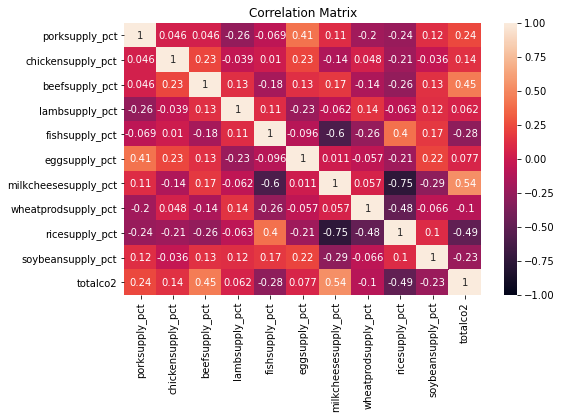

In [73]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(food_pct.corr(), annot=True, vmin=-1, ax=ax)
plt.title('Correlation Matrix');

We see that certain pairings of our features have strong correlation:
- rice supply & milkcheese supply: -0.75
- fish supply & milkcheese supply: -0.6
- pork supply & egg supply: 0.41

Certain features also have stronger correlation with our y variable `totalco2`:
- milkcheese supply: 0.54
- rice supply: -0.49
- beef supply: 0.45

But nothing particularly interesting, or any immediate reason that these variables would have the noted correlations. We can keep this matrix in mind when performing feature selection, as we want to prevent collinearity and improve our AIC/Adj. $R^2$ by keeping our chosen covariates distinct.

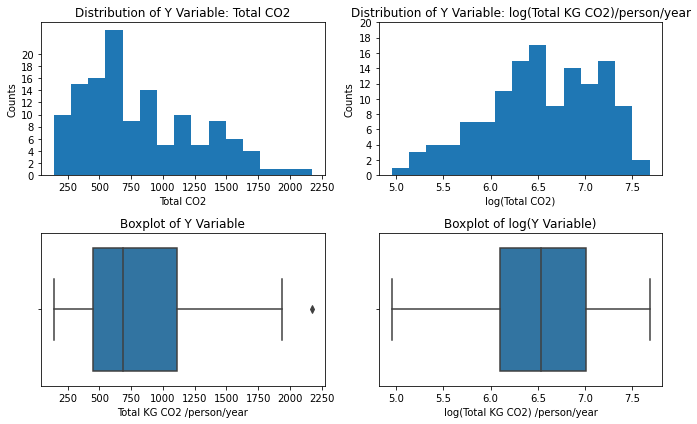

In [74]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.hist(food_pct['totalco2'], bins = np.linspace(food_pct['totalco2'].min(), food_pct['totalco2'].max(), 16));
plt.title('Distribution of Y Variable: Total CO2')
plt.xlabel('Total CO2')
plt.yticks(np.arange(0, 21, 2))
plt.ylabel('Counts')

plt.subplot(2,2,2)
plt.hist(np.log(food_pct['totalco2']), bins = np.linspace(np.log(food_pct['totalco2']).min(), 
                                                            np.log(food_pct['totalco2']).max(), 16));
plt.title('Distribution of Y Variable: log(Total KG CO2)/person/year')
plt.xlabel('log(Total CO2)')
plt.yticks(np.arange(0, 21, 2))
plt.ylabel('Counts')

plt.subplot(2,2,3)
sns.boxplot(food_pct['totalco2'])
plt.xlabel('Total KG CO2 /person/year')
plt.title('Boxplot of Y Variable')

plt.subplot(2,2,4)
sns.boxplot(np.log(food_pct['totalco2']))
plt.xlabel('log(Total KG CO2) /person/year')
plt.title('Boxplot of log(Y Variable)')

plt.tight_layout()

Our Y variable is right skewed, but is not so strong where we need a log transformation for our model. We may try using transformations to improve our model later on, but for now, we will move forward without any variable transformations.

Here is the distribution of the **average American diet** according to our data.

In [75]:
names = ['Pork', 'Chicken', 'Beef', 'Lamb', 'Fish', 'Eggs', 'Milk&Cheese', 'Wheat', 'Rice', 'Soybeans']
usa = food_pct[food_pct['Country'] == 'USA'].drop(columns=['Country', 'totalco2']).rename(columns=dict(zip(food_pct.columns[:-1], names)))
usa

,Pork,Chicken,Beef,Lamb,Fish,Eggs,Milk&Cheese,Wheat,Rice,Soybeans
5,0.057191,0.103478,0.074986,0.00089,0.025554,0.030168,0.526992,0.166422,0.014236,0.000083


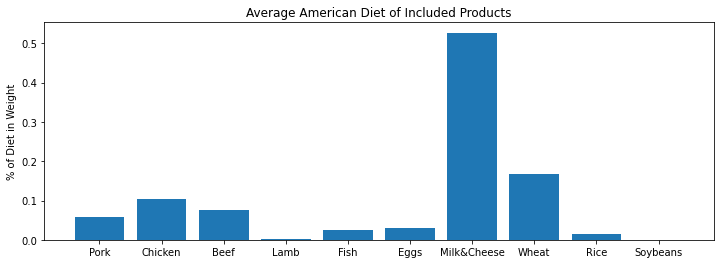

In [76]:
plt.figure(figsize=(12,4))
plt.bar(usa.columns, usa.to_numpy()[0])
plt.title('Average American Diet of Included Products')
plt.ylabel('% of Diet in Weight');

---

Even though we are not looking at country location in our model, we thought it'd be interesting to plot it spatially and see if there are any trends or clusters that have higher kgCO2/person/year.

Using this [guide](https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10) as a basis, we plot a world map of the KG CO2 emissions per person.

In [77]:
country_co2 = food_pct.loc[:, ['totalco2', 'Country']]
country_co2.rename(columns = {'Country' : 'CountryName'}, inplace=True)
country_co2.head()

,totalco2,CountryName
0,2172.40,Argentina
1,1938.64,Australia
2,1777.84,Albania
3,1731.35,Iceland
4,1750.94,New Zealand


In [78]:
#installation
# !pip install pycountry-convert

#function to convert to alpha2 country codes and continents
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    
    return (cn_a2_code, cn_continent)

In [79]:
codes = country_co2['CountryName'].apply(get_continent)

country_co2['Country'] = [code[0] for code in codes]
country_co2['Continent'] = [code[1] for code in codes]
country_co2.head()

,totalco2,CountryName,Country,Continent
0,2172.40,Argentina,AR,SA
1,1938.64,Australia,AU,OC
2,1777.84,Albania,AL,EU
3,1731.35,Iceland,IS,EU
4,1750.94,New Zealand,NZ,OC


In [80]:
#installation
# !pip install geopy

#function to get longitude and latitude data from country name
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="nu3-data-analysis")
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return (np.nan, np.nan)

In [81]:
# add latitude and longitudes based on country name
latlons = country_co2['Country'].apply(geolocate)

country_co2['Latitude'] = [latlon[0] for latlon in latlons]
country_co2['Longitude'] = [latlon[1] for latlon in latlons]
country_co2.head()

,totalco2,CountryName,Country,Continent,Latitude,Longitude
0,2172.40,Argentina,AR,SA,-34.996496,-64.967282
1,1938.64,Australia,AU,OC,-24.776109,134.755000
2,1777.84,Albania,AL,EU,33.258882,-86.829534
3,1731.35,Iceland,IS,EU,64.984182,-18.105901
4,1750.94,New Zealand,NZ,OC,-41.500083,172.834408


In [82]:
country_co2.loc[country_co2['Latitude'].isna(), :]

,totalco2,CountryName,Country,Continent,Latitude,Longitude
21,1405.70,Israel,IL,AS,NaN,NaN
107,241.92,Ethiopia,ET,AF,NaN,NaN
121,282.62,India,IN,AS,NaN,NaN


In [83]:
# removing the missing values as an easy way to see the world map
country_co2_clean = country_co2.loc[~country_co2['Latitude'].isna(), :]

In [84]:
#installation
# !pip install folium

# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster

#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(country_co2_clean)):
        lat = country_co2_clean.iloc[i]['Latitude']
        long = country_co2_clean.iloc[i]['Longitude']
        radius=5
        popup_text = """Country : {}<br>
                    kgCO2/person/year : {}<br>"""
        popup_text = popup_text.format(country_co2_clean.iloc[i]['CountryName'],
                                   country_co2_clean.iloc[i]['totalco2']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

A lot of the locations on the map have the incorrect latitudes and longitudes, but it is still interesting to look at and play around with!

#### Another map:

In [92]:
# !pip install country-converter

import country_converter as coco

country_co2['CountryCode'] = coco.convert(names=country_co2['Country'].to_list(), to='ISO3') # ignore the error

Unknown not found in regex
Unknown not found in regex


In [93]:
import plotly.express as px

fig = px.choropleth(country_co2, locations="CountryCode",
                    color="totalco2", 
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [89]:
# top 10 highest CO2 emissions per person per year according to our data
data.iloc[0:10, 0:2]

,#,Country
0,1,Argentina
1,2,Australia
2,3,Albania
3,4,Iceland
4,5,New Zealand
5,6,USA
6,7,Uruguay
7,8,Luxembourg
8,9,Brazil
9,10,Kazakhstan


A more appropriate map, and what I was looking for when I was creating the previous map. We see that North American, South American, and Australia tend to have the higher CO2 emissions per person per year. I'm surprised that Argentina is the highest rank.